In [533]:
import pandas as pd
import numpy as np

In [534]:
#Import the WDI data
data=pd.read_csv("/Users/leoss/Downloads/P_Data_Extract_From_WDI_Database_Archives-1/wdi_data_capstone_2_11.csv")
data.drop(columns=['Series Code', 'Version Name', 'Version Code'], inplace=True)

#Standardise them into long format
id_cols = [
    'Country Name', 'Country Code', 'Series Name'
]
Values=[f"{i} "+f"[YR{i}]" for i in range(1991,2025)]
data_long = data.melt(
    id_vars=id_cols, 
    value_vars=Values,
    var_name='Year',  
    value_name='Value'    
)

#Coerce all non numerics into Missing data 
data_long['Value'] = pd.to_numeric(data_long['Value'], errors='coerce')
data_long['Year'] = data_long['Year'].str.extract(r'(\d{4})').astype(int)
final_cols = id_cols + ['Year', 'Value']
df_long = data_long[final_cols]
#print(data_long)

# If you are interested in dropping some variables, input them here
series_to_drop = ['Tax revenue (% of GDP)', 'Central government debt, total (% of GDP)']
df_cleaned = df_long[~df_long['Series Name'].isin(series_to_drop)]
#df_cleaned["Country Name"]

In [535]:
#Import Trade data on complexity
trade=pd.read_csv("/Users/leoss/Downloads/growth_proj_eci_rankings.csv")
columns1 = ["country_id",'growth_proj', 'in_rankings', 'eci_sitc', 'eci_rank_sitc','eci_rank_hs92', 'eci_hs12', 'eci_rank_hs12']
trade.drop(columns1, inplace=True, axis=1) 

#Standardise names and order
trade["Series Name"]="Economic Complexity"
trade = trade.rename(columns={
    "country_iso3_code": "Country Code",
    "Country":"Country Name",
    "year": "Year",
    "eci_hs92": "Value"
})
new_order = ['Country Code','Series Name', 'Year', 'Value' ]
trade = trade[new_order]

In [536]:
#Import imf dataset
ins = ["COUNTRY.ID", "COUNTRY", "INDICATOR", "TIME_PERIOD", 
       "OBS_VALUE", "SCALE.ID", "PRIMARY_DOMESTIC_CURRENCY"]
imf = pd.read_csv(
    "/Users/leoss/Downloads/WorldEconomicOutlook-1.csv", 
    usecols=ins
)
#Only include relevant variables
imf = imf[ins]

#Dropping all observations without an associated time period and rename 
imf["TIME_PERIOD"].dropna(inplace=True)
imf = imf.rename(columns={
    "COUNTRY.ID": "Country Code",
    "COUNTRY":"Country Name",
    "TIME_PERIOD": "Year",
    "INDICATOR":"Series Name",
    "OBS_VALUE": "Value"
})

#Extract value scaled
imf["Value"]=imf["Value"]*10**(imf["SCALE.ID"])

#Drop those as not needed anymore
imf.drop(columns=["SCALE.ID","PRIMARY_DOMESTIC_CURRENCY"], inplace=True)

#Choose variables of interest
raw_list = [
    "Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021",
    "Current account balance (credit less debit), US dollar",
    "Revenue, General government, Percent of GDP"
]
variables_to_keep = [s.strip() for s in raw_list]
imf = imf[imf['Series Name'].isin(variables_to_keep)].query("Year>1990 & Year<2025")

In [537]:
#Get unique country codes from each database
codes_cleaned = set(df_cleaned['Country Code'].unique())
codes_trade = set(trade['Country Code'].unique())
codes_imf = set(imf['Country Code'].unique())
common_codes = codes_cleaned.intersection(codes_trade, codes_imf)
print(f"Found {len(common_codes)} countries common to all datasets.")

#Filter the original dataframes to keep only the common codes
df_cleaned_filtered = df_cleaned[df_cleaned['Country Code'].isin(common_codes)].copy()
trade_filtered = trade[trade['Country Code'].isin(common_codes)].copy()
imf_filtered = imf[imf['Country Code'].isin(common_codes)].copy()

#Final merge
final_dataset = pd.concat([df_cleaned_filtered, trade_filtered, imf_filtered], ignore_index=True)
final_dataset.sort_values(by=['Country Code', 'Year'], inplace=True)
final_dataset.dropna(subset=['Country Code'], inplace=True)
#final_dataset["Series Name"].value_counts()

##The final dataset will struggle with Name-Code matchings
"""
country_name_map = final_dataset.groupby('Country Code')['Country Name'].unique().reset_index()
def clean_name_list(name_list):
    clean_list = []
    for name in name_list:
        if pd.notna(name):
            clean_list.append(str(name))
    return clean_list

country_name_map['Cleaned_Names'] = country_name_map['Country Name'].apply(clean_name_list)
country_name_map['Valid_Name_Count'] = country_name_map['Cleaned_Names'].apply(len)

# Check for duplicate names for the same Country Code
conflicts_found = False
no_name_count = 0
single_name_count = 0

for index, row in country_name_map.iterrows():
    code = row['Country Code']
    names = row['Cleaned_Names']
    count = row['Valid_Name_Count']
    if count > 1:
        print(f"Code:'{code}' maps to multiple names: {names}")
        conflicts_found = True
    elif count == 0:
        print(f"Code': {code}' only has missing (NaN) Country Names associated with it.")
        no_name_count += 1
    else:
        single_name_count += 1

print(f"\nTotal codes with one unique name: {single_name_count}")
print(f"Total codes with no valid name: {no_name_count}")
print(f"Total unique codes checked: {len(country_name_map)}")
"""
#Manually fixing the names:
mapping={"AFG":'Afghanistan',
         'ARM':'Armenia',
         'AZE':'Azerbaijan',
         'BHR':'Bahrain',
         'BLR':'Belarus',
         'CHN':'China',
         'CIV':"Cote d'Ivoire",
         'COD':'Congo Dem. Rep.',
         'COG':'Congo',
         'EGY':"Egypt",
         'EST':'Estonia',
         'ETH':'Ethiopia',
         'GNQ':'Equatorial Guinea',
         'HKG':'Hong Kong',
         'HRV':'Croatia',
         'IRN':'Iran',
         'KAZ':'Kazakhstan',
         'LAO':'Laos',
         "LTU":'Lithuania',
         'LVA':'Latvia',
         'MDA':'Moldova',
         'KOR':'South Korea',
         'KAZ':'Kazakhstan',
         'MDG':'Madagascar',
         'MKD':'North Macedonia',
         'MOZ':'Mozambique',
         'MRT':'Mauritania',
         'NLD':'Netherlands',
         'POL':'Poland',
         'RUS':'Russia',
         'SRB':'Serbia',
         'SVN':'Slovenia',
         'SWZ':'Eswatini',
         'TJK':'Tajikistan',
         'TUR':'Turkey',
         'TWN':'Taiwan',
         'UZB':'Uzbekistan',
         'VEN':'Venezuela',
         'YEM':'Yemen'
         }
# Create a Series of new names from the map
new_names = final_dataset['Country Code'].map(mapping)
final_dataset['Country Name'] = new_names.fillna(final_dataset['Country Name'])

#Now generate code-name pairing, to fill missing country-names
valid_names = final_dataset.dropna(subset=['Country Name'])
code_to_name_map_df = valid_names.drop_duplicates(subset=['Country Code'])
clean_map_dict = pd.Series(
    code_to_name_map_df['Country Name'].values, 
    index=code_to_name_map_df['Country Code']
).to_dict()
filled_names = final_dataset['Country Code'].map(clean_map_dict)
final_dataset['Country Name'] = final_dataset['Country Name'].fillna(filled_names)

Found 144 countries common to all datasets.


In [538]:
#Import plotting means 
import matplotlib.pyplot as plt
import seaborn as sns

Total Unique Indicators (Perfect Score for a Country): 11
Total Unique Countries (Perfect Score for a Variable): 145


/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_6124/1320106651.py:31: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_6124/1320106651.py:44: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




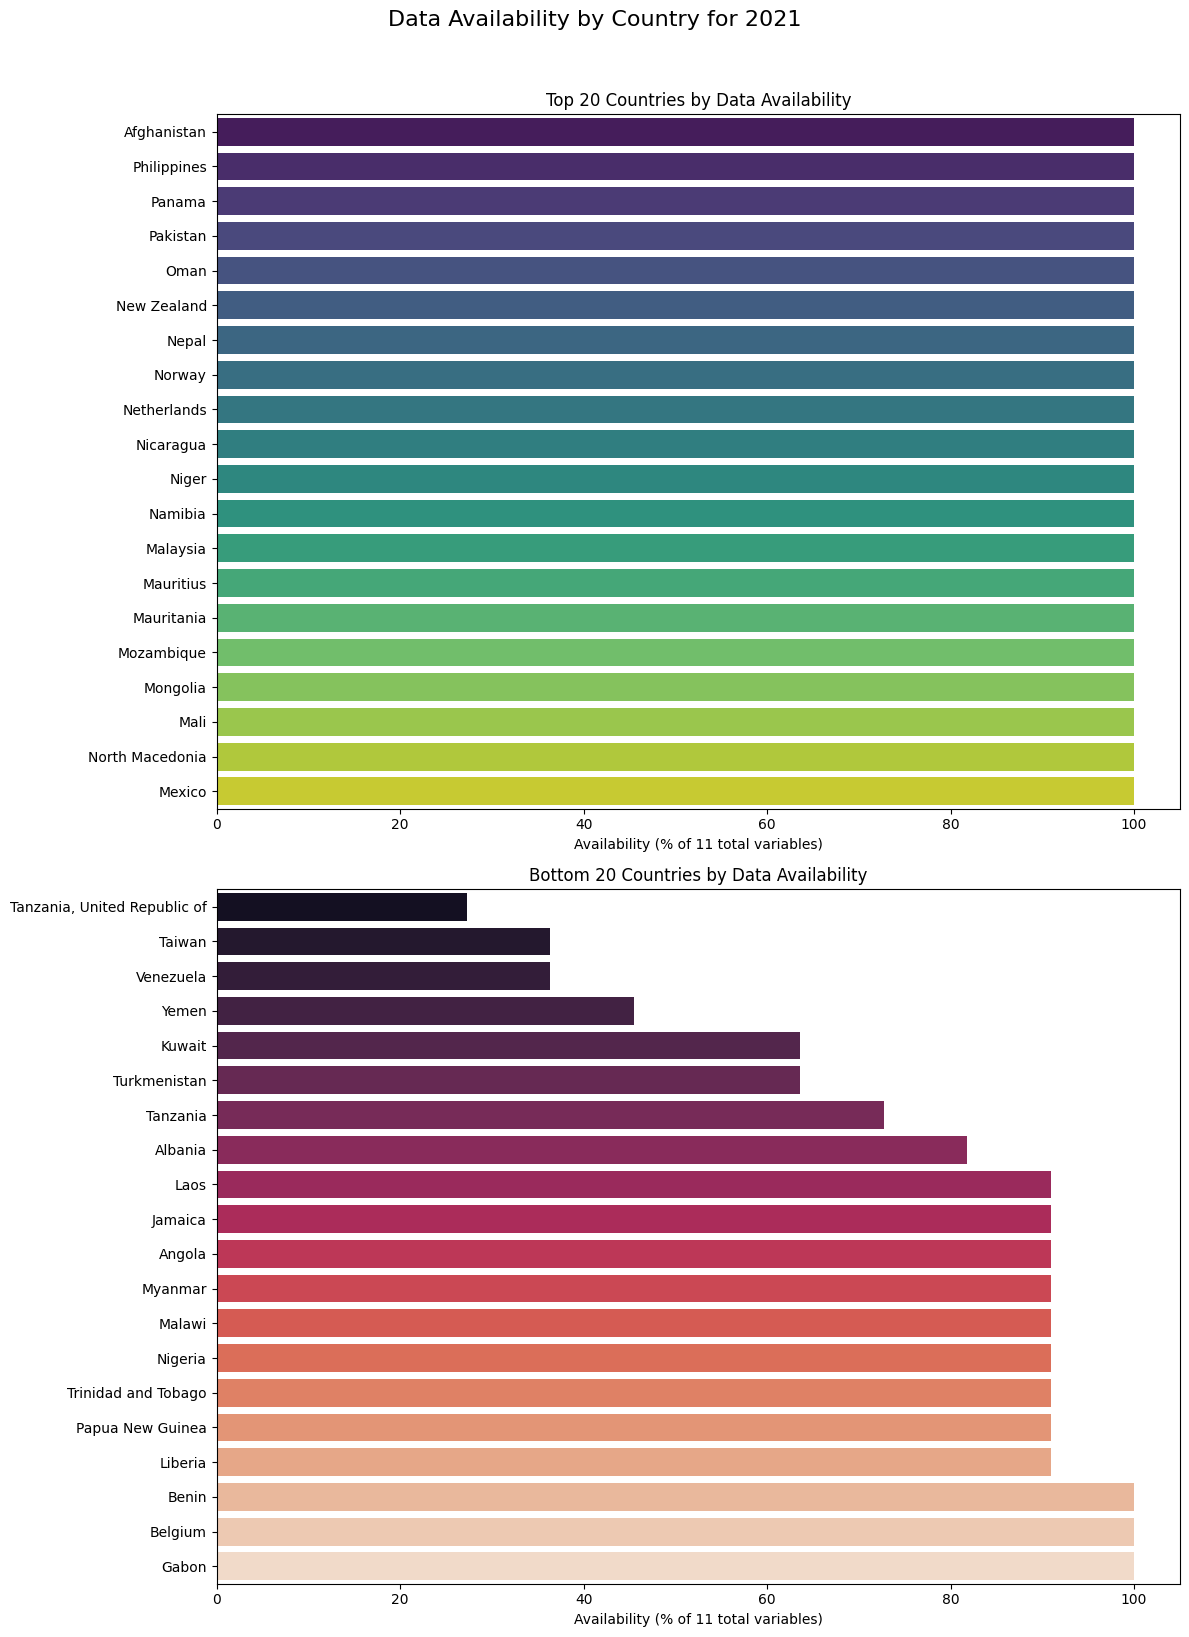

/var/folders/lk/thldsylx4nx779cggs7gnk900000gn/T/ipykernel_6124/1320106651.py:82: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




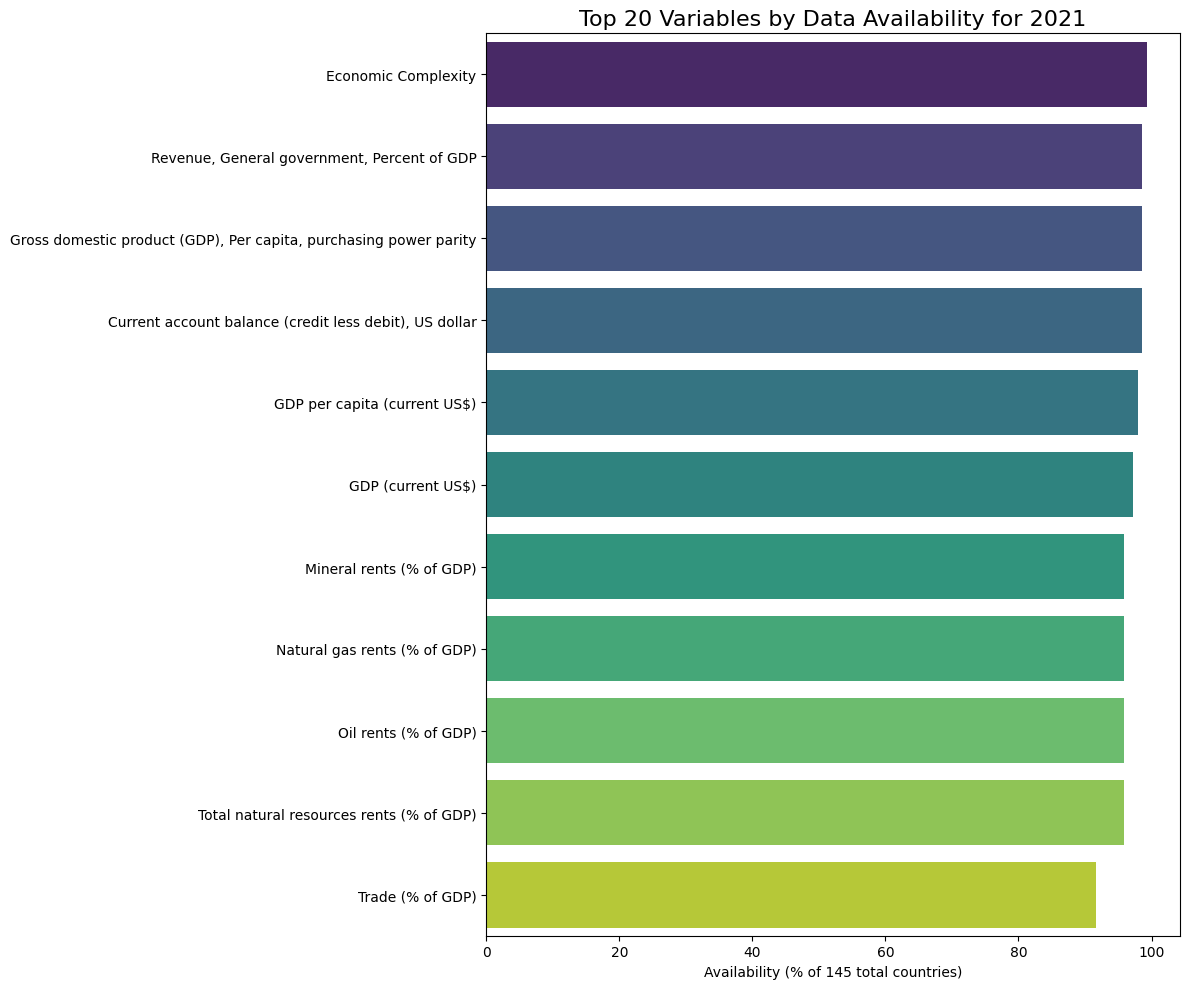

In [539]:
#Use 2021 as a reference point 
ref_year = 2021
df_year = final_dataset.query("Year == @ref_year")

#Generate expected variables to compute missing variables vis a vis the expeted amount of them (datasets are not complete)
TOTAL_EXPECTED_VARIABLES = final_dataset['Series Name'].nunique()
TOTAL_EXPECTED_COUNTRIES = final_dataset['Country Name'].nunique()
print(f"Total Unique Indicators (Perfect Score for a Country): {TOTAL_EXPECTED_VARIABLES}")
print(f"Total Unique Countries (Perfect Score for a Variable): {TOTAL_EXPECTED_COUNTRIES}")

#Master list of ALL countries
all_countries = final_dataset['Country Name'].unique()
availability_country = pd.DataFrame({'Country Name': all_countries})
available_points_country = df_year.groupby('Country Name')['Value'].count().reset_index().rename(columns={'Value': 'Available_Points'})

#Combine, fill 0s for countries with no data in ref_year
availability_country = availability_country.merge(available_points_country, on='Country Name', how='left')
availability_country['Available_Points'] = availability_country['Available_Points'].fillna(0)

#Denominator: Use the single global "expected" number
availability_country['Total_Variables'] = TOTAL_EXPECTED_VARIABLES
availability_country['Availability_Pct'] = (availability_country['Available_Points'] / availability_country['Total_Variables']) * 100
availability_country = availability_country.sort_values(by='Availability_Pct', ascending=False)

#Availability by country
fig1, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 16))
fig1.suptitle(f'Data Availability by Country for {ref_year}', fontsize=16, y=1.02)

#Top 20 Countries
top_20_countries = availability_country.head(20)
sns.barplot(
    data=top_20_countries,
    x='Availability_Pct',
    y='Country Name',
    palette='viridis',
    ax=ax1
)
ax1.set_title('Top 20 Countries by Data Availability')
ax1.set_xlabel(f'Availability (% of {TOTAL_EXPECTED_VARIABLES} total variables)')
ax1.set_ylabel('')

#Bottom 20 Countries
bottom_20_countries = availability_country.tail(20).sort_values(by='Availability_Pct', ascending=True)
sns.barplot(
    data=bottom_20_countries,
    x='Availability_Pct',
    y='Country Name',
    palette='rocket',
    ax=ax2
)
ax2.set_title('Bottom 20 Countries by Data Availability')
ax2.set_xlabel(f'Availability (% of {TOTAL_EXPECTED_VARIABLES} total variables)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

#Master list of ALL variables
all_variables = final_dataset['Series Name'].unique()
availability_variable = pd.DataFrame({'Series Name': all_variables})

#Count available non-NA points for the ref_year

available_points_variable = df_year.groupby('Series Name')['Value'].count().reset_index().rename(columns={'Value': 'Available_Points'})

#Combine, fill 0s for variables with no data in ref_year
availability_variable = availability_variable.merge(available_points_variable, on='Series Name', how='left')
availability_variable['Available_Points'] = availability_variable['Available_Points'].fillna(0)

#Use the single global "expected" number
availability_variable['Total_Countries'] = TOTAL_EXPECTED_COUNTRIES
availability_variable['Availability_Pct'] = (availability_variable['Available_Points'] / availability_variable['Total_Countries']) * 100
availability_variable = availability_variable.sort_values(by='Availability_Pct', ascending=False)

#Plotting by Variable (Top 20 Only)

top_20_variables = availability_variable.head(20).copy()
top_20_variables['Short_Name'] = top_20_variables['Series Name'].apply(lambda s: ' '.join(str(s).split()[:9]))


plt.figure(figsize=(12, 10))
sns.barplot(
    data=top_20_variables,
    x='Availability_Pct',
    y='Short_Name',  
    palette='viridis'
)
plt.title(f'Top 20 Variables by Data Availability for {ref_year}', fontsize=16)
plt.xlabel(f'Availability (% of {TOTAL_EXPECTED_COUNTRIES} total countries)')
plt.ylabel('') # Set y-axis label to empty
plt.tight_layout()
plt.show()

In [540]:
# Here we start with the clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
import plotly.figure_factory as ff
import plotly.express as px

In [541]:
#Prepare and scale data
#Unfortunately we have to drop missing variables now
data_clean = df_year.dropna(subset=['Value'])

#Obtain wide format (I dont know how to do it in long)
data_wide = data_clean.pivot(index='Country Name', columns='Series Name', values='Value')
data_wide_imputed = data_wide.fillna(data_wide.mean())

#Drop some variables 
columns=["Current account balance (credit less debit), US dollar","GDP per capita (current US$)","GDP (current US$)"]
data_wide_imputed.drop(columns=columns, inplace=True)

#Scale the filtered values
scaler_filtered = StandardScaler()
countries_scaled_filtered_df = pd.DataFrame(
    scaler_filtered.fit_transform(data_wide_imputed), 
    columns=data_wide_imputed.columns, 
    index=data_wide_imputed.index
)

In [555]:
data_wide_imputed

Series Name,Economic Complexity,"Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP benchmarks 2017-2021",Mineral rents (% of GDP),Natural gas rents (% of GDP),Oil rents (% of GDP),"Revenue, General government, Percent of GDP",Total natural resources rents (% of GDP),Trade (% of GDP)
Country Name,,,,,,,,
Afghanistan,-1.133,2138.870000,0.000000,0.001954,0.017870,17.449000,0.428525,51.411716
Albania,-0.368,16354.589000,0.180214,0.049458,1.042184,27.084203,1.442601,75.590322
Algeria,-0.846,14556.823000,0.003787,7.995729,14.461565,26.229000,22.590270,46.837059
Angola,-1.250,26162.327986,0.000000,1.012349,28.274440,20.679000,29.967435,74.464499
Argentina,-0.436,26015.237000,0.580267,0.389397,1.544382,33.550000,2.653089,33.078690
...,...,...,...,...,...,...,...,...
Venezuela,-1.125,6128.963000,2.285285,0.959689,3.205131,7.284000,7.748587,86.076221
Vietnam,0.160,12101.363000,0.102201,0.327308,0.669314,18.693000,2.547017,186.675833
Yemen,-1.432,1672.917000,2.285285,0.959689,3.205131,7.331000,7.748587,86.076221


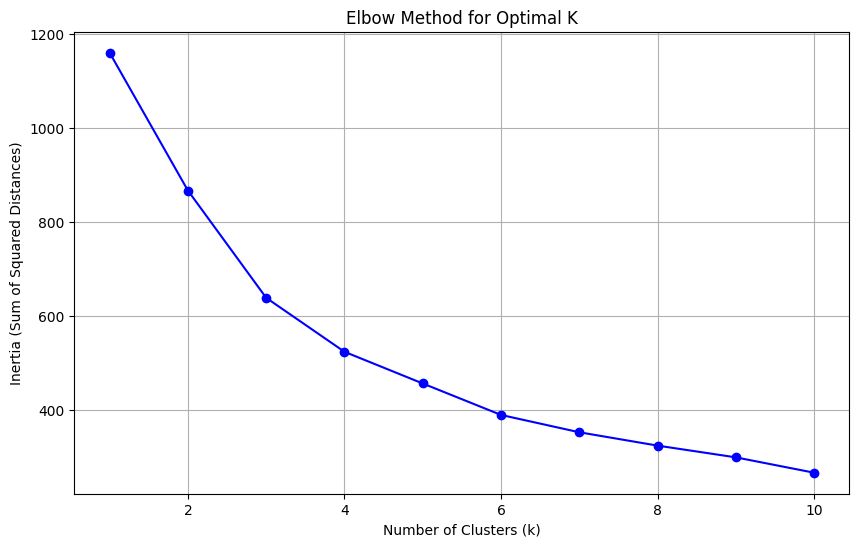

In [542]:
# Do the k-elbow plot
inertia = []
K_range = range(1, 11) 

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=20) 
    kmeans.fit(countries_scaled_filtered_df)
    inertia.append(kmeans.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, 'bo-') 
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal K')
plt.grid(True)
plt.show()

In [552]:
final_dataset["Series Name"].value_counts()

Series Name
Mineral rents (% of GDP)                                                                                                  4896
Natural gas rents (% of GDP)                                                                                              4896
Oil rents (% of GDP)                                                                                                      4896
Total natural resources rents (% of GDP)                                                                                  4896
Trade (% of GDP)                                                                                                          4896
GDP (current US$)                                                                                                         4896
GDP per capita (current US$)                                                                                              4896
Gross domestic product (GDP), Per capita, purchasing power parity (PPP) international dollar, ICP b

In [ ]:
# K-cluster with 4 and 6 clusters
k_country_4_filtered = KMeans(n_clusters=4, random_state=0, n_init=100)
k_country_4_filtered.fit(countries_scaled_filtered_df)
countries_scaled_filtered_df['cluster_4'] = k_country_4_filtered.labels_
k_country_6_filtered = KMeans(n_clusters=6, random_state=0, n_init=100)
k_country_6_filtered.fit(countries_scaled_filtered_df.drop(columns=['cluster_4'])) 
countries_scaled_filtered_df['cluster_6'] = k_country_6_filtered.labels_

# Print cluster (k=4)
print("\nCluster sizes (k=4):")
print(countries_scaled_filtered_df.groupby('cluster_4').size())
for cluster, item in countries_scaled_filtered_df.groupby('cluster_4'):
    clustered_countries = item.index.tolist()
    print(f"\nCluster {cluster} (k=4):")
    print(*clustered_countries, sep=', ')

# Print cluster (k=6)
print("\nCluster sizes (k=6):")
print(countries_scaled_filtered_df.groupby('cluster_6').size())
for cluster, item in countries_scaled_filtered_df.groupby('cluster_6'):
    clustered_countries = item.index.tolist()
    print(f"\nCluster {cluster} (k=6):")
    print(*clustered_countries, sep=', ')


Cluster sizes (k=4):
cluster_4
0    12
1    44
2    75
3    14
dtype: int64

Cluster 0 (k=4):
Australia, Burkina Faso, Chile, Congo Dem. Rep., Kazakhstan, Kyrgyz Republic, Mali, Mauritania, Mongolia, Papua New Guinea, Peru, Zambia

Cluster 1 (k=4):
Austria, Belarus, Belgium, Bosnia and Herzegovina, Bulgaria, Canada, Croatia, Cyprus, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hong Kong, Hungary, Ireland, Israel, Italy, Japan, Kuwait, Latvia, Lithuania, Malaysia, Netherlands, New Zealand, North Macedonia, Norway, Poland, Portugal, Romania, Serbia, Singapore, Slovak Republic, Slovenia, South Korea, Spain, Sweden, Switzerland, Taiwan, United Arab Emirates, United Kingdom, United States

Cluster 2 (k=4):
Afghanistan, Albania, Argentina, Armenia, Bangladesh, Benin, Bolivia, Botswana, Brazil, Cambodia, Cameroon, Chad, China, Colombia, Costa Rica, Cote d'Ivoire, Dominican Republic, Ecuador, Egypt, El Salvador, Eswatini, Ethiopia, Gabon, Georgia, Ghana, Guatemala, Guin

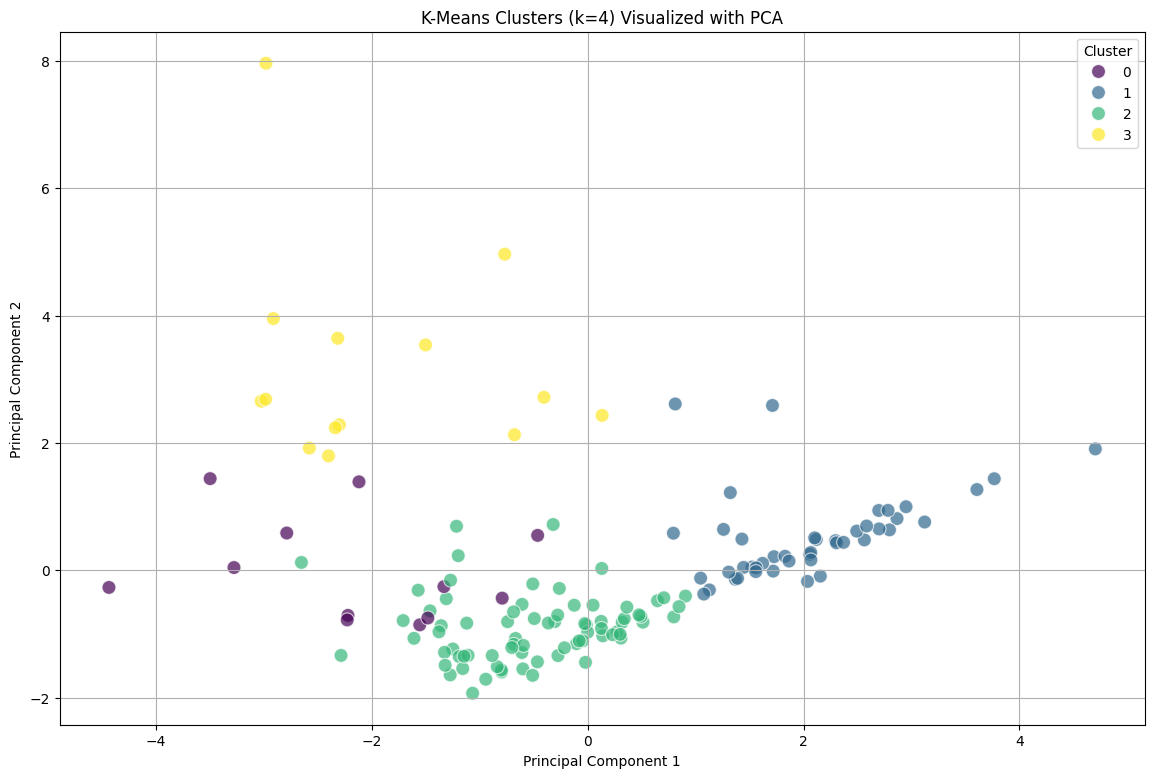

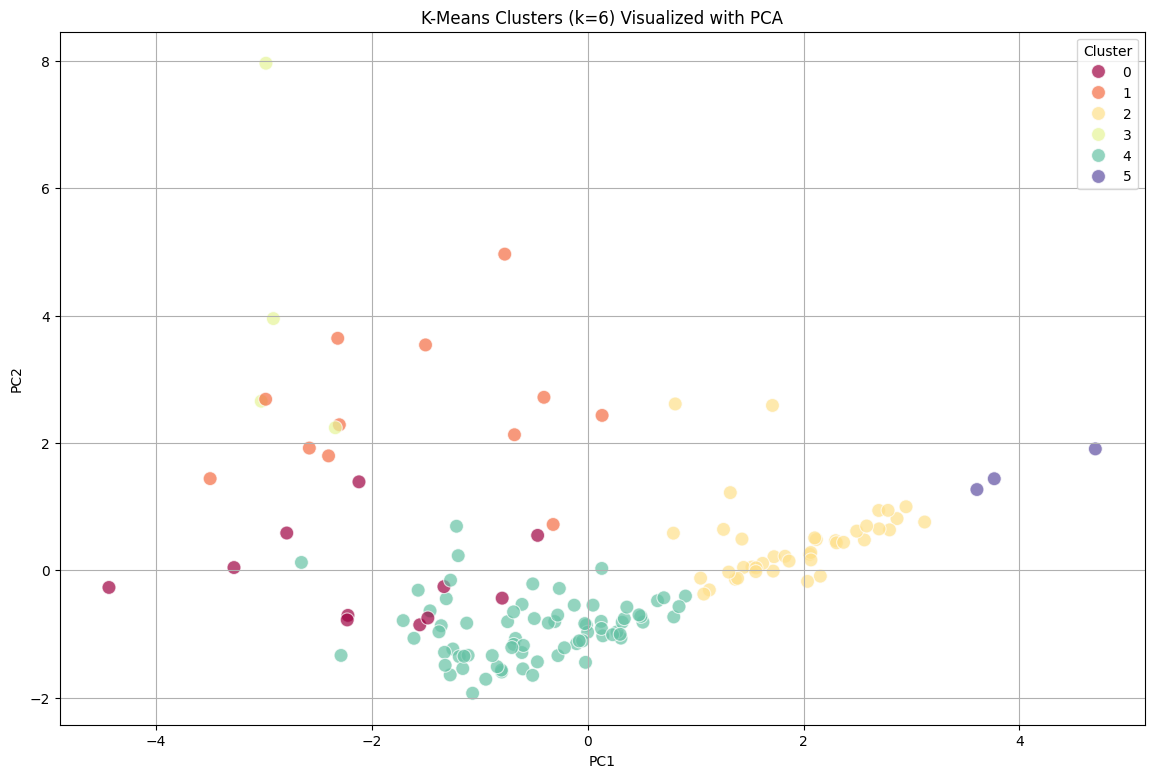

In [ ]:
#Run PCA on the original scaled data
data_for_pca = countries_scaled_filtered_df.drop(columns=['cluster_4', 'cluster_6'])
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_for_pca)

#Create a new DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(
    data=pca_components, 
    columns=['PC1', 'PC2'], 
    index=data_for_pca.index
)
pca_df['cluster_4'] = countries_scaled_filtered_df['cluster_4']
pca_df['cluster_6'] = countries_scaled_filtered_df['cluster_6']
pca_df['Country Code'] = pca_df.index 
pca_df['Country Name'] = pca_df.index.map(clean_map_dict)

#Choose countries to label 
countries_to_label = ['USA', 'CHN', 'RUS', 'AGO'] 
label_data = pca_df[pca_df.index.isin(countries_to_label)]

#Plot the (k=4) cluster
plt.figure(figsize=(14, 9))
ax = sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='cluster_4', 
    palette='viridis', s=100, alpha=0.7
)
plt.title('K-Means Clusters (k=4) Visualized with PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)

#Display country of interest
for i, row in label_data.iterrows():
    ax.annotate(
        row['Country Code'], 
        (row['PC1'], row['PC2']),             
        textcoords="offset points", xytext=(5, 5), ha='center',
        fontsize=9, color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc='yellow', ec='none', alpha=0.5)
    )
plt.show()

#Plot the (k=6) cluster
plt.figure(figsize=(14, 9))
ax = sns.scatterplot(
    data=pca_df, x='PC1', y='PC2', hue='cluster_6',
    palette='Spectral', s=100, alpha=0.7
)
plt.title('K-Means Clusters (k=6) Visualized with PCA')
plt.legend(title='Cluster')
plt.grid(True)

# Display country of interest
for i, row in label_data.iterrows():
    ax.annotate(
        row['Country Code'], 
        (row['PC1'], row['PC2']),
        textcoords="offset points", xytext=(5, 5), ha='center',
        fontsize=9, color='black',
        bbox=dict(boxstyle="round,pad=0.3", fc='yellow', ec='none', alpha=0.5)
    )
plt.show()

In [ ]:
#Recreate country code map
try:
    country_code_map = data_clean[['Country Name', 'Country Code']].drop_duplicates().set_index('Country Name')
except KeyError:
    print("Warning: 'Country Code' column not found.")
    country_code_map = pd.DataFrame(index=data_clean['Country Name'].unique())
    country_code_map['Country Code'] = country_code_map.index

#Drop any stale cluster columns that might be present
stale_cols = ['cluster_6', 'cluster_4', 'cluster_6', 'Country Code', 'Country Name']
for col in stale_cols:
    if col in pca_df.columns:
        pca_df = pca_df.drop(columns=[col])

#Copy clusters
pca_df['cluster_4'] = countries_scaled_filtered_df['cluster_4']
pca_df['cluster_6'] = countries_scaled_filtered_df['cluster_6']

#Join the code/name map
if 'Country Code' not in pca_df.columns:
    pca_df = pca_df.join(country_code_map)
if 'Country Name' not in pca_df.columns:
    pca_df['Country Name'] = pca_df.index

#Create the interactive k=4 plot
fig = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2', 
    color='cluster_4',
    hover_name='Country Code',
    hover_data={               
        'Country Name': True, 
        'cluster_4': True,
        'PC1': ':.2f',
        'PC2': ':.2f'
    },
    title='Interactive PCA Plot of K-Means Clusters (k=4) - Hover by Country Code'
)
fig.update_traces(marker=dict(size=10, opacity=0.8))
fig.show()

# Interactive plots for k=6
fig8 = px.scatter(
    pca_df, 
    x='PC1', 
    y='PC2', 
    color='cluster_6',
    hover_name='Country Code', 
    hover_data={
        'Country Name': True,
        'cluster_6': True, 
        'PC1': ':.2f',
        'PC2': ':.2f'
    },
    title='Interactive PCA Plot of K-Means Clusters (k=6) - Hover by Country Code'
)
fig8.update_traces(marker=dict(size=10, opacity=0.8))
fig8.show()

Re-creating country_code_map...
Columns available in pca_df: ['PC1', 'PC2', 'cluster_4', 'cluster_6', 'Country Code', 'Country Name']



--- Step 4: Interpreting Clusters with Heatmap ---


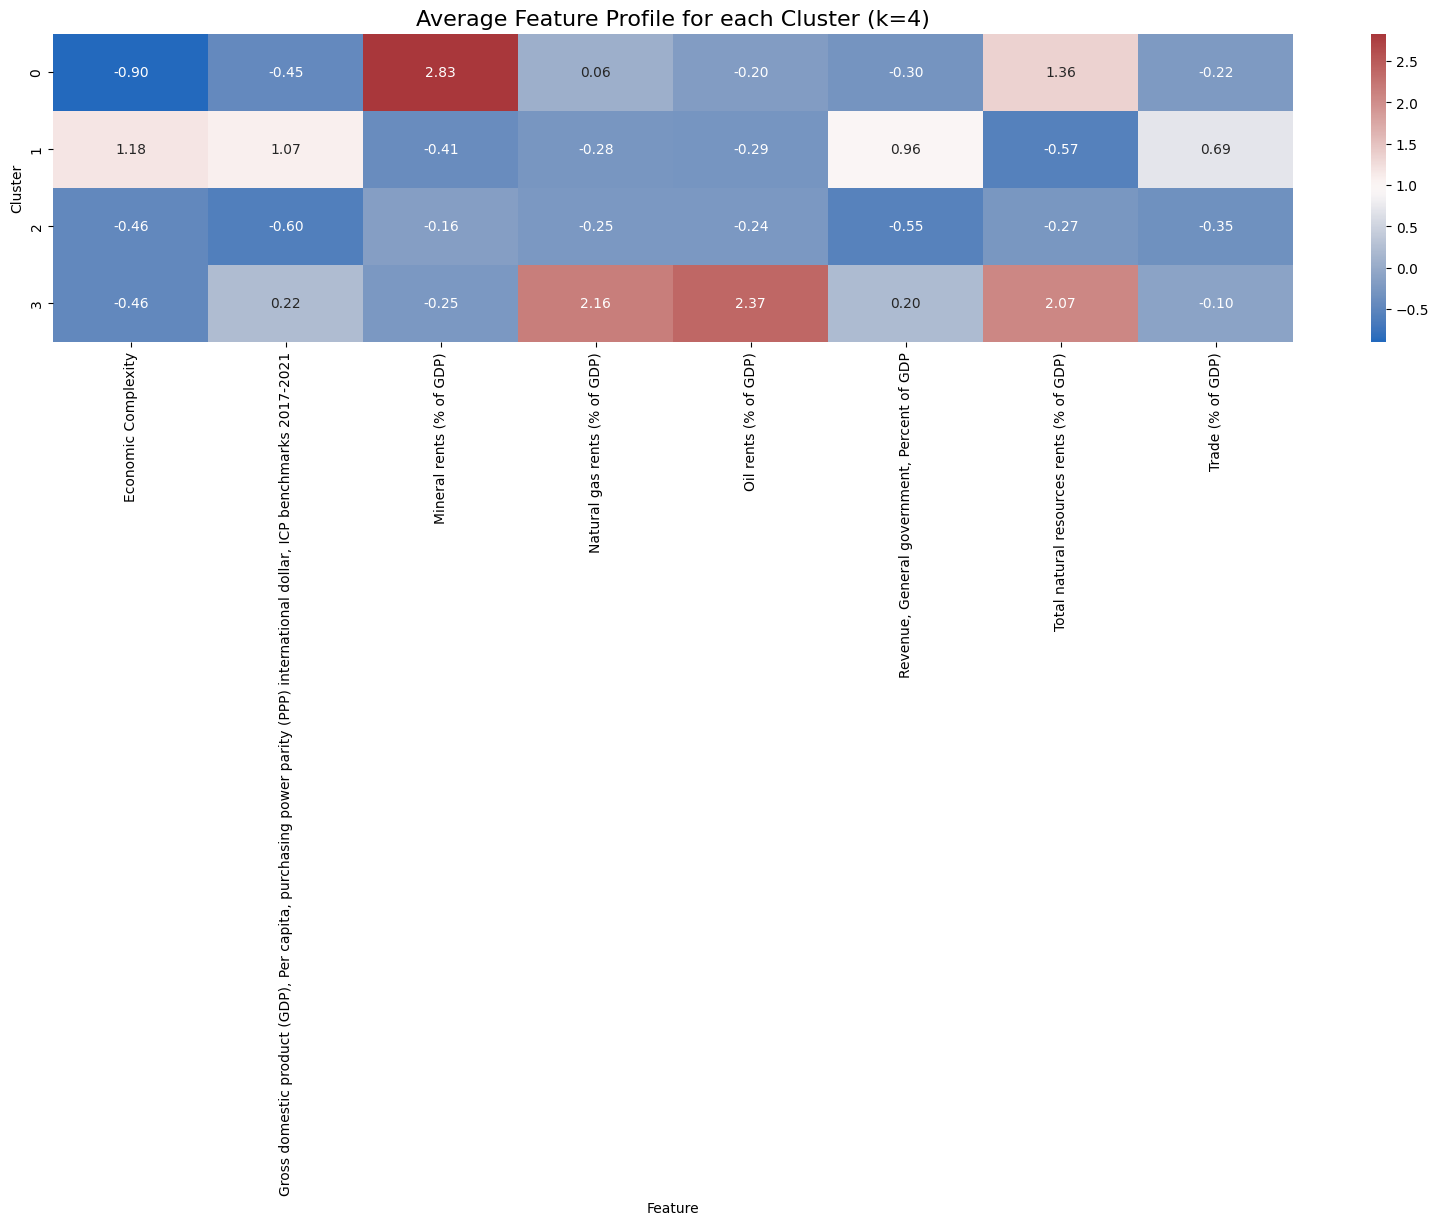

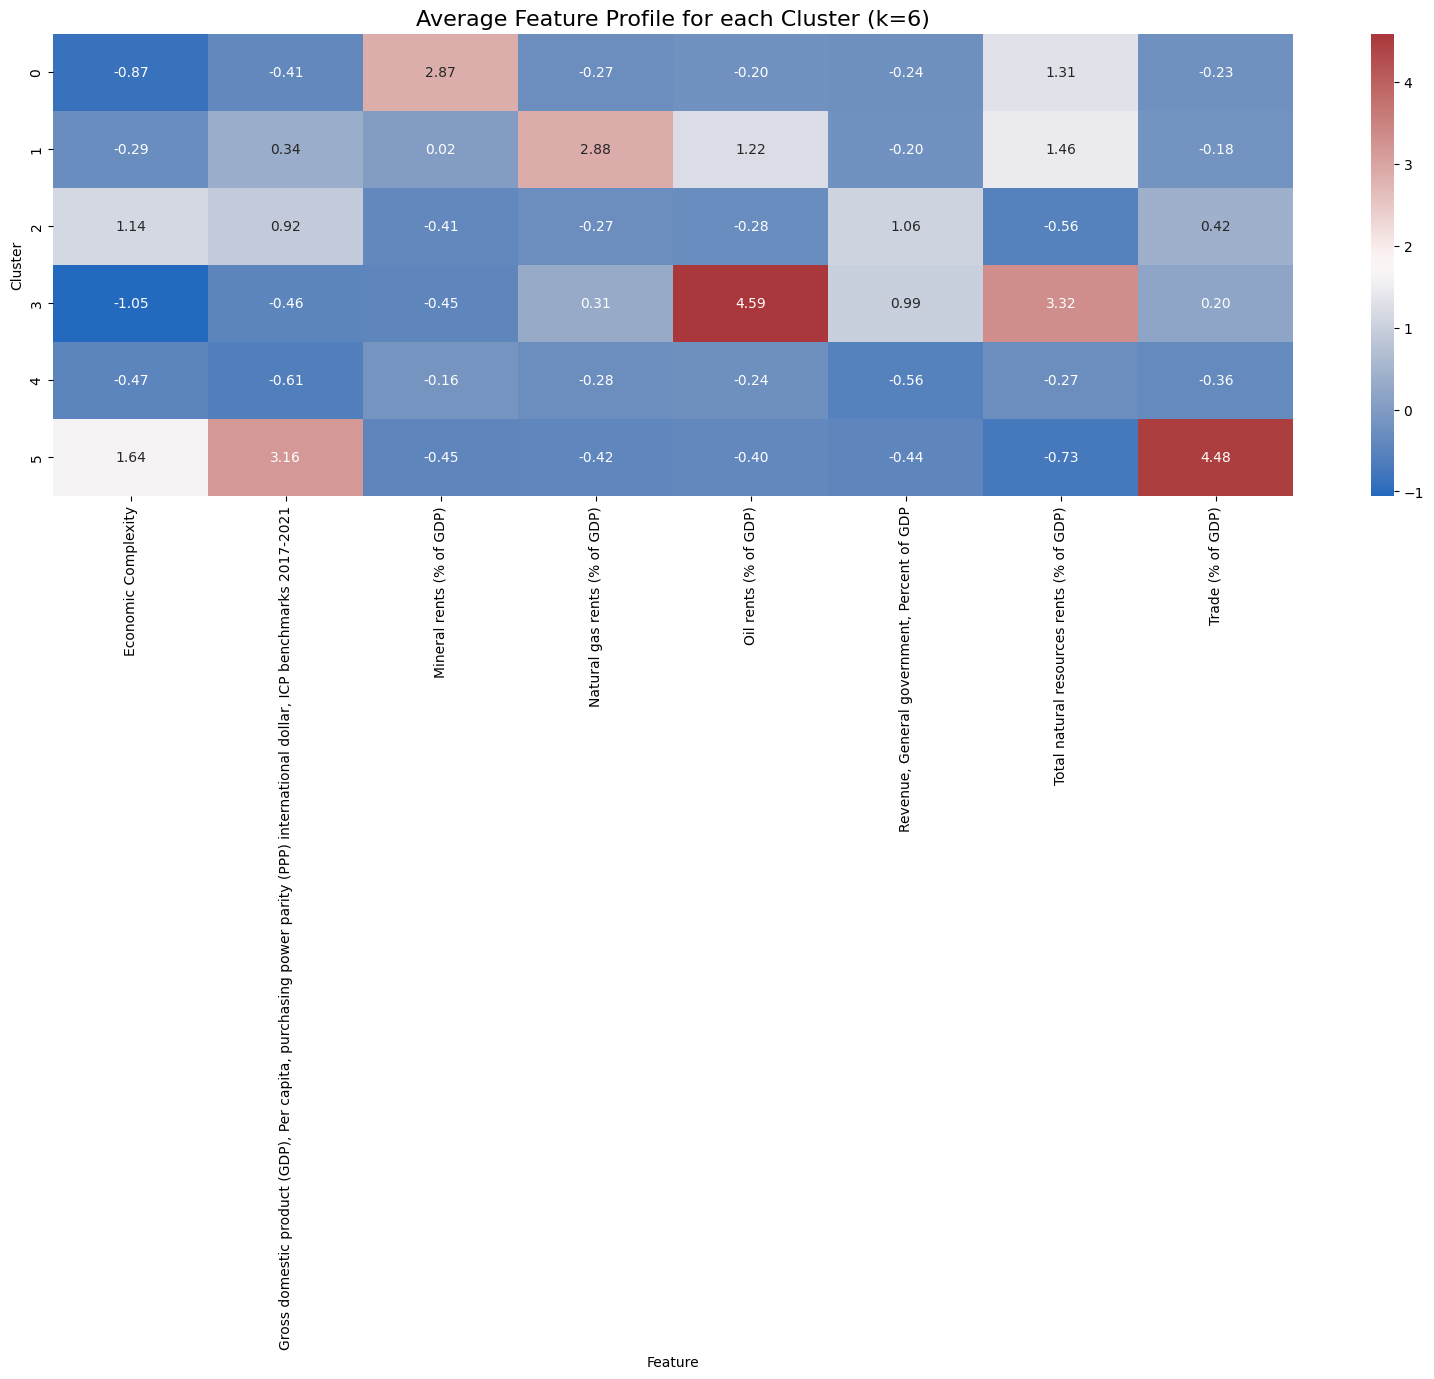

In [553]:
#Get Centroids (Average Profiles)
centroids_k4 = k_country_4_filtered.cluster_centers_
centroid_df_k4 = pd.DataFrame(
    centroids_k4, 
    columns=data_for_pca.columns 
)
centroids_k6 = k_country_6_filtered.cluster_centers_
centroid_df_k6 = pd.DataFrame(
    centroids_k6, 
    columns=data_for_pca.columns 
)

#Plot Heatmaps 
plt.figure(figsize=(20, 4))
sns.heatmap(
    centroid_df_k4, 
    annot=True,     
    cmap='vlag',    
    fmt='.2f'       
)
plt.title('Average Feature Profile for each Cluster (k=4)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()

plt.figure(figsize=(20, 6)) 
sns.heatmap(
    centroid_df_k6, 
    annot=True, 
    cmap='vlag', 
    fmt='.2f'
)
plt.title('Average Feature Profile for each Cluster (k=6)', fontsize=16)
plt.ylabel('Cluster')
plt.xlabel('Feature')
plt.show()